#                 Spam Detection with Deep Leatning Method

# Step1 Brief description 

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.


The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

-> A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. 

-> A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. 

-> A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis.

-> Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages.  This corpus has been used in the following academic researches:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re, string, unicodedata
from string import punctuation
from termcolor import colored
from collections import Counter

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras
import tensorflow as tf
from keras.preprocessing import text, sequence

from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

In [2]:
spam_path = r'E:\Jia\Desktop\MS-DS\5511 Introduction to Deep Learning\week6\spam.csv'
data = pd.read_csv(spam_path,encoding='latin')

In [3]:
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


This dataset includes 5572 rows and 5 columns, we can see the first two columns are without proper names, and there are null values in the rest of columns, let's clean the dataset first.

# Step2 EDA
## 2.1 Clean the data

In [5]:
data.rename(columns = {'v1':'target', 'v2':'text'}, inplace=True)

In [6]:
data.drop(data.columns[[2,3,4]], axis=1, inplace=True)

In [7]:
data

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Here are decoding the labels. We map 0--Ham and 1--Spam as directed by the dataset description. 

In [9]:
data['target'] = data['target'].apply(lambda x: 1 if x == 'spam' else 0)

In [10]:
data

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [11]:
len(data[data['target']==0]['text'].values)

4825

In [12]:
len(data[data['target']==1]['text'].values)

747

In [47]:
data[data['target']==0]['text'].values[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [48]:
data[data['target']==1]['text'].values[0]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

Text(0.5, 1.0, 'Count for ham: 4825\nCount for spam: 747')

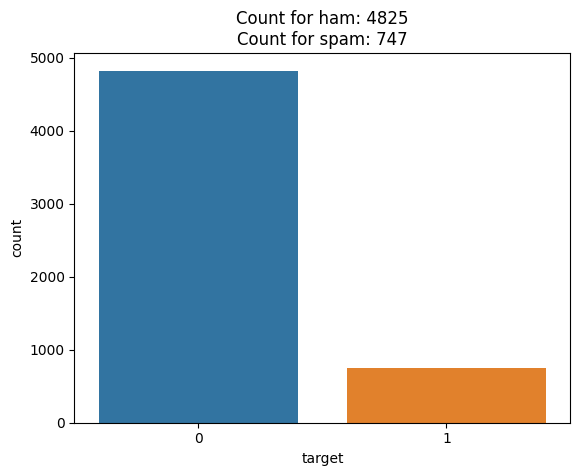

In [49]:
sns.countplot(x=data.target)
plt.title('Count for ham: 4825' + '\n' + 'Count for spam: 747')

## 2.2 Process the data
### 1. Make text lowercase, remove text in square brackets,remove links,remove punctuation and remove words containing numbers

In [50]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [51]:
data['text_clean'] = data['text'].apply(clean_text)

In [57]:
data.head()

,target,text,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


### 2. Stopwords

In [53]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [44]:
data['text_clean'] = data['text_clean'].apply(remove_stopwords)

In [45]:
data

,target,text,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts m...
3,0,U dun say so early hor... U c already then say...,dun say early hor already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,time tried contact å£ pound prize claim eas...
5568,0,Will Ì_ b going to esplanade fr home?,ì b going esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestions
5570,0,The guy did some bitching but I acted like i'd...,guy bitching acted like id interested buying s...


### 3. Stemming/Lematization

In [46]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [23]:
data['text_clean'] = data['text_clean'].apply(stemm_text)

In [24]:
data

,target,text,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts m...
3,0,U dun say so early hor... U c already then say...,dun say earli hor alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,time tri contact å£ pound prize claim easi ...
5568,0,Will Ì_ b going to esplanade fr home?,ì b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",piti mood soani suggest
5570,0,The guy did some bitching but I acted like i'd...,guy bitch act like id interest buy someth els ...


### 4.Tokenization
Tokenize the data and convert the text to sequences.
Add padding to ensure that all the sequences have the same shape.

In [25]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(data['text_clean'].values)
X = tokenizer.texts_to_sequences(data['text_clean'].values)
X = pad_sequences(X)

In [26]:
X.shape

(5572, 68)

In [58]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    2,
        276,  564,  531, 1013,   41,   62,  251, 1014,   90, 2236, 1015,
         17,   69])

In [28]:
y = data['target']
print(len(X), len(y))

5572 5572


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =123)

In [30]:
X_train

array([[   0,    0,    0, ...,  471,  694, 1342],
       [   0,    0,    0, ...,   61,   24, 1963],
       [   0,    0,    0, ...,   85,  188,   74],
       ...,
       [   0,    0,    0, ...,  992,    3,  642],
       [   0,    0,    0, ...,  765,    4,  235],
       [   0,    0,    0, ...,  158,  405,   66]])

In [31]:
y_train

385     0
4003    0
1283    0
2327    1
1103    0
       ..
5218    0
4060    0
1346    0
3454    0
3582    0
Name: target, Length: 4457, dtype: int64

# Step3 Deep learning model

In [32]:
model = Sequential()
model.add(Embedding(input_dim = 5572, output_dim = 64, name='Embedding'))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LSTM(128))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.0002), metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, None, 64)          356608    
                                                                 
 lstm (LSTM)                 (None, None, 128)         98816     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [33]:
history = model.fit(X_train, y_train, epochs = 15, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/15
70/70 [==============================] - 5s 32ms/step - loss: 0.4466 - accuracy: 0.8622 - val_loss: 0.3109 - val_accuracy: 0.8807
Epoch 2/15
70/70 [==============================] - 2s 23ms/step - loss: 0.2571 - accuracy: 0.8622 - val_loss: 0.1641 - val_accuracy: 0.8807
Epoch 3/15
70/70 [==============================] - 2s 22ms/step - loss: 0.1166 - accuracy: 0.9571 - val_loss: 0.0636 - val_accuracy: 0.9821
Epoch 4/15
70/70 [==============================] - 2s 23ms/step - loss: 0.0524 - accuracy: 0.9870 - val_loss: 0.0493 - val_accuracy: 0.9865
Epoch 5/15
70/70 [==============================] - 2s 23ms/step - loss: 0.0339 - accuracy: 0.9899 - val_loss: 0.0461 - val_accuracy: 0.9874
Epoch 6/15
70/70 [==============================] - 2s 22ms/step - loss: 0.0254 - accuracy: 0.9935 - val_loss: 0.0448 - val_accuracy: 0.9874
Epoch 7/15
70/70 [==============================] - 2s 23ms/step - loss: 0.0188 - accuracy: 0.9960 - val_loss: 0.0586 - val_accuracy: 0.9848
Epoch 8/15
70

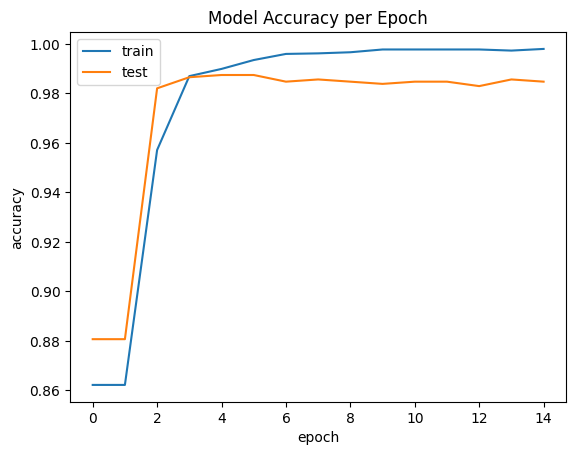

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')
plt.show();

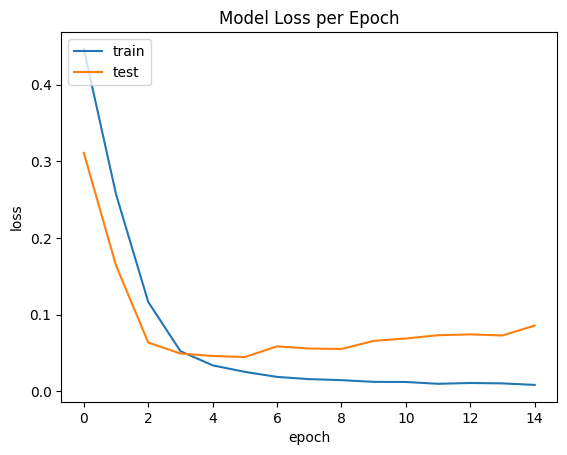

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

35/35 [==============================] - 1s 6ms/step


<AxesSubplot: >

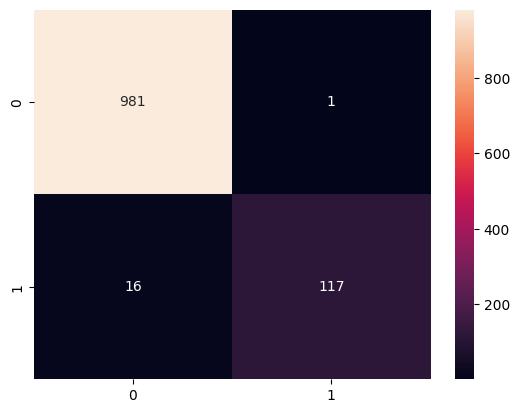

In [36]:
from sklearn import metrics
y_preds = (model.predict(X_test) > 0.5).astype("int32")
conf = metrics.confusion_matrix(y_test, y_preds)
sns.heatmap(conf, annot=True, fmt='d')

In [37]:
metrics.roc_auc_score(y_test, y_preds)

0.9393404590907003

# Step4 Results and analysis

After renaming and dropping null value columns from the raw dataset, my new dataset includes 5572 rows and 2 columns. When decoding the labels, I map 0----ham and 1---spam as directed by the dataset description.4 thousand 8 hundred twenty five cases belong to ham, and 7 hundred forty seven cases are identified to spam.

To process the data, what I do is make text lowercase, remove text in square brackets, remove links, remove punctuation, remove words containing numbers, dealing with stopwords, stemming/Lemmatization,  and Tokenize the data and convert the text to sequences. Add padding to ensure that all the sequences have the same shape.

LSTM has 3 gates:(1) Forget Gate: - It decides which information from the previous timestamp is irrelevant and can be forgotten. It has the first neural network layer with sigmoid function. (2) Input Gate: Try to learn new information from the input to the cell. It has 2 neural layers, first one with sigmoid activation function and second one with tanh function. First, a sigmoid layer called the “input gate layer” decides which values to update. Next, the tanh layer creates a vector of new candidate values. (3) Output Gate: It passes the information from the current timestamp to the next. It has a sigmoid activation function.

I created a LSTM model which includes activation function of dense layer, embedding, dropout, loss function and optimizer. Adam is used as an optimizer which is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. Default learning rate of Adam is 0.001, but here I have initialized it to 0.0002. I set epochs equal to 15. Based on the plot and graph we can see the accuracy of the model is increasing. Especially after epoch 3, it reached above 95%, and the accuracy of these models still appears to be improving after 15 epochs. And the value of loss function drops off sharply when epoch from 1 to 3.I study the confusion matrix and calculate the area under the receiver operating characteristic curve (ROC AUC) from prediction scores which is approximately 0.94 which is good.

# Step5 Conclusion

In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it. The pretrained Word Embedding like GloVe & Word2Vec gives more insights for a word which can be used for classification. I am going to try those methods to process data in the future. 

To build my sequential neural network model, I used the LSTM model to analyze the dataset, but I notice the accuracy of model appears to increase after 15 epochs, I am going to try more epochs in the further study and experiment different learning rate for Adam function.